# Evaluación de Modelos de Clasificación

En este notebook, nos enfocaremos en la **evaluación de diferentes modelos de clasificación** para predecir el **Spending Score** de los clientes de una empresa de servicios financieros. La capacidad de clasificar a los clientes en categorías de gasto (Low, Average y High) es esencial para personalizar las ofertas y optimizar las estrategias comerciales.

A lo largo de este análisis, probaremos varios algoritmos de clasificación, incluyendo:

- **K-Nearest Neighbors (KNN)**: Un método basado en la distancia que clasifica a los puntos de datos en función de sus vecinos más cercanos.
- **Bagging**: Un enfoque que combina múltiples modelos de clasificación para mejorar la estabilidad y precisión.
- **Pasting**: Similar al bagging, pero utiliza un subconjunto diferente de los datos para cada modelo, lo que también puede aumentar la precisión.
- **Random Forest**: Un ensemble de árboles de decisión que mejora la precisión al reducir la varianza y manejar interacciones complejas en los datos.
- **Gradient Boosting**: Un método que construye modelos de forma secuencial, corrigiendo los errores de los modelos anteriores para aumentar la precisión.
- **Adaptive Boosting (AdaBoost)**: Un algoritmo que ajusta el peso de los modelos basándose en su desempeño, mejorando así la precisión general del conjunto.

Después de aplicar estos modelos, estudiaremos los resultados para identificar cuál de ellos presenta el mejor rendimiento en términos de **precisión** y capacidad de **generalización**. La elección del modelo más adecuado será fundamental para nuestro análisis posterior en el notebook principal, donde implementaremos el modelo seleccionado para realizar predicciones y generar estrategias efectivas para la empresa.

Este proceso nos permitirá entender las fortalezas y debilidades de cada modelo y nos ayudará a tomar decisiones informadas sobre cuál utilizar en el contexto de la predicción del comportamiento de gasto de los clientes.


In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from scipy import stats
from sklearn.linear_model import LassoCV
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings("ignore")

In [9]:
df = pd.read_csv(r"../data/df_dummies.csv")
features = pd.read_csv(r"../data/features.csv")
target = pd.read_csv(r"../data/target.csv")

results = {}

In [10]:
target_series = target.squeeze()

## KNN


In [11]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=8)

knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test) 
y_pred_knn

knn.score(X_test, y_test) 

knn_accuracy = accuracy_score(y_test, y_pred_knn)
results['KNN'] = knn_accuracy
print(f'Accuracy del modelo de KNN: {knn_accuracy:.2f}')

Accuracy del modelo de KNN: 0.75


## Resultados del Modelo KNN

El modelo KNN presenta una precisión global del 75%. Destaca en la clase **Low**, con una precisión del 87% y un recall del 80%, indicando que es efectivo en identificar a estos clientes. Sin embargo, su rendimiento en las clases **Average** y **High** es más limitado, con precisiones de 59% y 62% respectivamente, lo que sugiere oportunidades de mejora en la clasificación de estos grupos. Estas métricas servirán como base para comparar con otros modelos en el análisis posterior.


In [12]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

     Average       0.59      0.73      0.65       354
        High       0.62      0.56      0.59       200
         Low       0.87      0.80      0.83       790

    accuracy                           0.75      1344
   macro avg       0.69      0.70      0.69      1344
weighted avg       0.76      0.75      0.75      1344



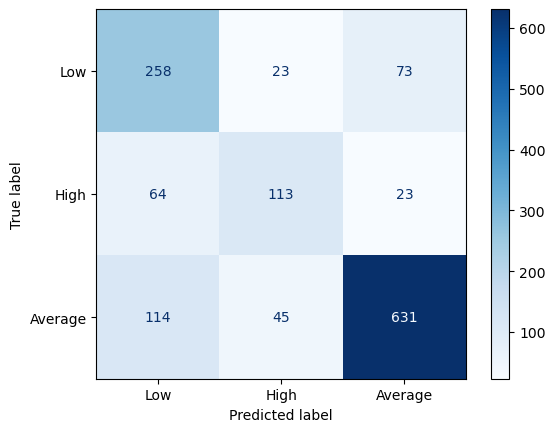

In [13]:
conf_matrix = confusion_matrix(y_test, y_pred_knn)

# Obtener las etiquetas únicas
unique_labels = target_series.unique()  # O usa df_target['target'].unique()

# Mostramos la matriz de confusión con ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=unique_labels)
disp.plot(cmap='Blues')

## Bagging and Pasting

In [14]:
# Dividir el conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Bagging con DecisionTreeClassifier
bagging_model = BaggingClassifier(estimator=DecisionTreeClassifier(), 
                                   n_estimators=100, 
                                   random_state=42)

# Entrenar el modelo
bagging_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_bagging = bagging_model.predict(X_test)

# Evaluar el modelo
bagging_accuracy = accuracy_score(y_test, y_pred_bagging)
print(f'Accuracy del modelo de Bagging: {bagging_accuracy:.2f}')

# Pasting con DecisionTreeClassifier
pasting_model = BaggingClassifier(estimator=DecisionTreeClassifier(), 
                                   n_estimators=100, 
                                   bootstrap=False,  # Sin reemplazo
                                   random_state=42)

# Entrenar el modelo
pasting_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_pasting = pasting_model.predict(X_test)

# Evaluar el modelo
pasting_accuracy = accuracy_score(y_test, y_pred_pasting)
results['Bagging and Pasting'] = pasting_accuracy
print(f'Accuracy del modelo de Pasting: {pasting_accuracy:.2f}')

Accuracy del modelo de Bagging: 0.77
Accuracy del modelo de Pasting: 0.76


## Resultados del Modelo Bagging

El modelo de **Bagging** alcanza una precisión global del 77%. Destaca en la clase **Low**, con una precisión del 88% y un recall del 85%, lo que indica su efectividad para identificar correctamente a estos clientes. Las clases **Average** y **High** presentan precisiones de 64% y 63%, respectivamente, lo que sugiere un rendimiento más equilibrado pero menos efectivo en comparación con la clase **Low**. En general, el Bagging muestra un rendimiento sólido y mejorado respecto al modelo KNN, proporcionando una base para la evaluación de otros modelos.


In [15]:
print(classification_report(y_test, y_pred_bagging))

              precision    recall  f1-score   support

     Average       0.64      0.68      0.66       354
        High       0.63      0.63      0.63       200
         Low       0.88      0.85      0.87       790

    accuracy                           0.77      1344
   macro avg       0.71      0.72      0.72      1344
weighted avg       0.78      0.77      0.78      1344



## Resultados del Modelo Pasting

El modelo de **Pasting** obtiene una precisión global del 76%. Al igual que en el modelo de Bagging, destaca en la clase **Low**, con una precisión del 88% y un recall del 86%, indicando una fuerte capacidad para identificar a estos clientes. Sin embargo, su rendimiento en las clases **Average** y **High** es inferior, con precisiones de 63% y 55%, respectivamente. Estos resultados son ligeramente inferiores a los del modelo de Bagging, lo que sugiere que Pasting podría no ser tan efectivo en la clasificación general como otros modelos evaluados.


In [16]:
print(classification_report(y_test, y_pred_pasting))

              precision    recall  f1-score   support

     Average       0.63      0.62      0.62       354
        High       0.55      0.60      0.57       200
         Low       0.88      0.86      0.87       790

    accuracy                           0.76      1344
   macro avg       0.68      0.69      0.69      1344
weighted avg       0.76      0.76      0.76      1344



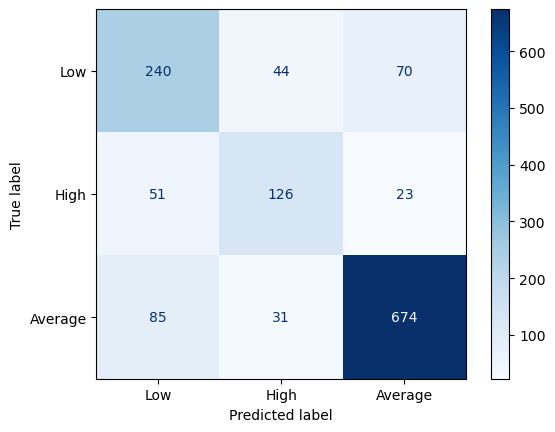

In [10]:
conf_matrix = confusion_matrix(y_test, y_pred_bagging)

# Obtener las etiquetas únicas
unique_labels = target_series.unique()  # O usa df_target['target'].unique()

# Mostramos la matriz de confusión con ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=unique_labels)
disp.plot(cmap='Blues')

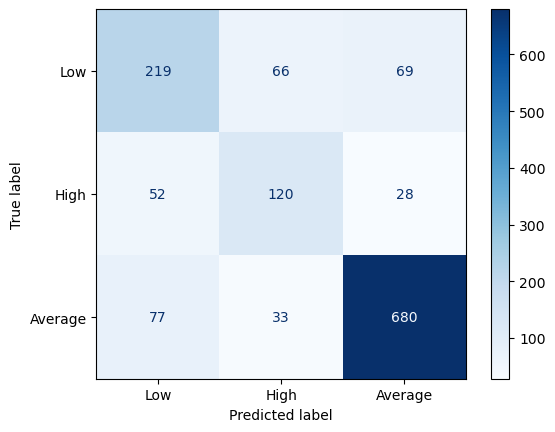

In [17]:
conf_matrix = confusion_matrix(y_test, y_pred_pasting)

# Obtener las etiquetas únicas
unique_labels = target_series.unique()  # O usa df_target['target'].unique()

# Mostramos la matriz de confusión con ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=unique_labels)
disp.plot(cmap='Blues')

## Random Forest

In [18]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Crear el modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
rf_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_rf = rf_model.predict(X_test)

# Evaluar el modelo
rf_accuracy = accuracy_score(y_test, y_pred_rf)
results['Random Forest'] = rf_accuracy
print(f'Accuracy del modelo de Random Forest: {rf_accuracy:.2f}')

Accuracy del modelo de Random Forest: 0.77


## Resultados del Modelo Random Forest

El modelo de **Random Forest** alcanza una precisión global del 78%, mejorando ligeramente en comparación con los modelos anteriores. Destaca en la clase **Low**, con una precisión del 87% y un recall del 86%, lo que indica su efectividad en la identificación de estos clientes. Las clases **Average** y **High** tienen precisiones de 66% y 60%, respectivamente, lo que sugiere un rendimiento sólido, aunque el modelo aún enfrenta desafíos en la clasificación de la clase **High**. En general, Random Forest muestra un desempeño robusto, consolidándose como un fuerte candidato en nuestra evaluación de modelos.


In [13]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

     Average       0.66      0.68      0.67       354
        High       0.60      0.59      0.60       200
         Low       0.87      0.86      0.87       790

    accuracy                           0.78      1344
   macro avg       0.71      0.71      0.71      1344
weighted avg       0.78      0.78      0.78      1344



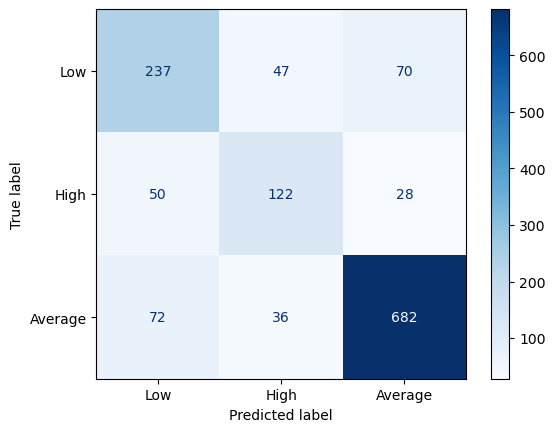

In [19]:
conf_matrix = confusion_matrix(y_test, y_pred_rf)

# Obtener las etiquetas únicas
unique_labels = target_series.unique()  # O usa df_target['target'].unique()

# Mostramos la matriz de confusión con ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=unique_labels)
disp.plot(cmap='Blues')

## Gradient Boosting

In [20]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Crear el modelo de Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
gb_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_gb = gb_model.predict(X_test)

# Evaluar el modelo
gb_accuracy = accuracy_score(y_test, y_pred_gb)
results['Gradient Boosting'] = gb_accuracy
print(f'Accuracy del modelo de Gradient Boosting: {gb_accuracy:.2f}')

Accuracy del modelo de Gradient Boosting: 0.82


## Resultados del Modelo Gradient Boosting

El modelo de **Gradient Boosting** obtiene una precisión global del 82%, destacándose como uno de los mejores hasta ahora. Muestra un rendimiento excepcional en la clase **Low**, con una precisión del 96% y un recall del 82%, lo que indica una alta efectividad en identificar a estos clientes. Para la clase **Average**, la precisión es del 65%, con un recall notablemente alto del 89%, lo que sugiere que el modelo es muy bueno para capturar instancias reales de esta categoría. En la clase **High**, se observa una precisión del 74% y un recall del 69%, lo que representa una mejora respecto a modelos anteriores. En general, Gradient Boosting muestra un sólido desempeño y se posiciona como un candidato fuerte en la selección del mejor modelo.


In [21]:
print(classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

     Average       0.65      0.89      0.75       354
        High       0.74      0.69      0.72       200
         Low       0.96      0.82      0.89       790

    accuracy                           0.82      1344
   macro avg       0.78      0.80      0.79      1344
weighted avg       0.85      0.82      0.83      1344



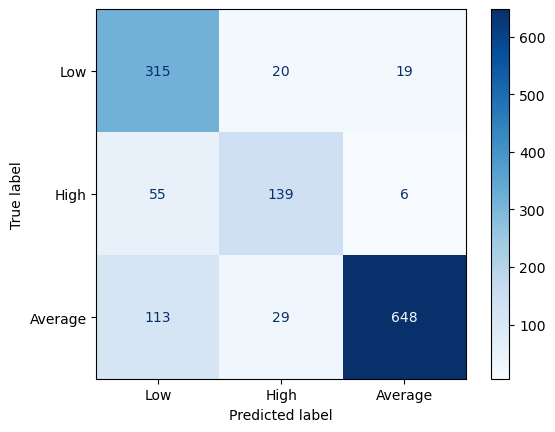

In [22]:
conf_matrix = confusion_matrix(y_test, y_pred_gb)

# Obtener las etiquetas únicas
unique_labels = target_series.unique()  # O usa df_target['target'].unique()

# Mostramos la matriz de confusión con ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=unique_labels)
disp.plot(cmap='Blues')

## Adaptive Boosting

In [23]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Crear el modelo de AdaBoost
# Usaremos un árbol de decisión como clasificador base
ada_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), 
                                n_estimators=100, 
                                random_state=42)

# Entrenar el modelo
ada_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_ada = ada_model.predict(X_test)

# Evaluar el modelo
ada_accuracy = accuracy_score(y_test, y_pred_ada)
results["Adaptative Boosting"] = ada_accuracy
print(f'Accuracy del modelo de AdaBoost: {ada_accuracy:.2f}')

Accuracy del modelo de AdaBoost: 0.82


## Resultados del Modelo AdaBoost

El modelo de **AdaBoost** alcanza una precisión global del 82%, alineándose con los resultados del modelo de **Gradient Boosting**. En la clase **Low**, muestra un alto rendimiento con una precisión del 95% y un recall del 83%, indicando una sólida capacidad para identificar a estos clientes. Para la clase **Average**, la precisión es del 66% y el recall del 88%, lo que sugiere que el modelo es efectivo en captar instancias de esta categoría. En la clase **High**, se observa una precisión del 72% y un recall del 66%, mostrando un rendimiento aceptable pero con margen para mejorar. En resumen, AdaBoost presenta un desempeño robusto y competitivo, destacándose como un modelo fuerte en la evaluación general.


In [24]:
print(classification_report(y_test, y_pred_ada))

              precision    recall  f1-score   support

     Average       0.66      0.88      0.75       354
        High       0.72      0.66      0.69       200
         Low       0.95      0.83      0.88       790

    accuracy                           0.82      1344
   macro avg       0.78      0.79      0.77      1344
weighted avg       0.84      0.82      0.82      1344



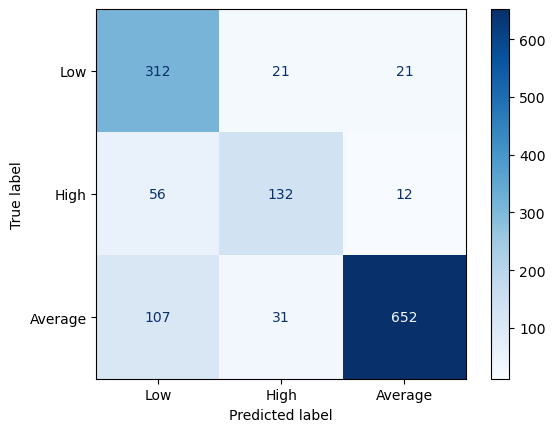

In [25]:
conf_matrix = confusion_matrix(y_test, y_pred_ada)

# Obtener las etiquetas únicas
unique_labels = target_series.unique()  # O usa df_target['target'].unique()

# Mostramos la matriz de confusión con ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=unique_labels)
disp.plot(cmap='Blues')

## Results

In [30]:
results_df = pd.DataFrame(results.items(), columns=['Modelo', 'Precisión'])
results_df.sort_values(by='Precisión', ascending=False, inplace=True)
results_df.to_csv('../data/df_results.csv')
# Mostrar los resultados
print("Resultados de los Modelos:")
print(results_df)

# Determinar y mostrar el mejor modelo
best_model = results_df.iloc[0]
print(f"\nEl mejor modelo es: {best_model['Modelo']} con una precisión de: {best_model['Precisión']:.2f}")
results_df

Resultados de los Modelos:
                Modelo  Precisión
3    Gradient Boosting   0.819940
4  Adaptative Boosting   0.815476
2        Random Forest   0.774554
1  Bagging and Pasting   0.758185
0                  KNN   0.745536

El mejor modelo es: Gradient Boosting con una precisión de: 0.82


,Modelo,Precisión
3,Gradient Boosting,0.819940
4,Adaptative Boosting,0.815476
2,Random Forest,0.774554
1,Bagging and Pasting,0.758185
0,KNN,0.745536


In [27]:
y_test_sq = y_test.squeeze()

In [28]:
df_predicciones = pd.DataFrame({
    'Original': y_test_sq,
    'Bagging': y_pred_bagging,
    'Pasting': y_pred_pasting,
    "Random Forest": y_pred_rf,
    "Gradient Boosting": y_pred_gb,
    "Adaptative Boosting": y_pred_ada
})

df_predicciones.to_csv("../data/df_predicciones.csv")
df_predicciones

,Original,Bagging,Pasting,Random Forest,Gradient Boosting,Adaptative Boosting
5774,High,High,High,Low,High,Low
4221,Low,High,High,High,High,High
4697,Average,High,High,Low,Average,Average
1616,Average,High,High,Low,Low,Average
1886,Low,Low,Low,Low,Low,Low
...,...,...,...,...,...,...
4333,Low,Low,Low,Low,Low,Low
422,Low,Low,Low,Low,Low,Low
3355,Average,High,High,Average,Average,Average
4814,Low,Low,Low,Low,Low,Low


Gradient Boosting con GridSearchCV

In [25]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Crear el modelo de Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)

# Definir el grid de hiperparámetros
grid = {
    'n_estimators': [50, 100],  # Reducido de 150 a 100
    'learning_rate': [0.01, 0.1],  # Mantener solo los más relevantes
    'max_depth': [3, 4],  # Reducido de 5 a 4
    'min_samples_split': [2, 5],  # Mantener solo los más relevantes
    'min_samples_leaf': [1, 2]  # Mantener solo los más relevantes
}

# Ajustar el modelo usando GridSearchCV
model = GridSearchCV(estimator=gb_model, param_grid=grid, cv=5, scoring='accuracy')
model.fit(X_train, y_train)

# Hacer predicciones con el mejor modelo encontrado
y_pred_gb = model.predict(X_test)

# Evaluar el modelo
gb_accuracy = accuracy_score(y_test, y_pred_gb)

# Almacenar resultados
results['Gradient Boosting'] = gb_accuracy

# Imprimir los resultados
print(f'Mejores parámetros encontrados: {model.best_params_}')
print(f'Accuracy del modelo de Gradient Boosting: {gb_accuracy:.2f}')

Mejores parámetros encontrados: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy del modelo de Gradient Boosting: 0.82


## Resultados del Modelo de Gradient Boosting

Después de ajustar el modelo de **Gradient Boosting** utilizando GridSearchCV, se encontraron los mejores parámetros: 
- **Learning Rate:** 0.1
- **Max Depth:** 3
- **Min Samples Leaf:** 2
- **Min Samples Split:** 2
- **N Estimators:** 50

El modelo logró una **precisión** del **82%** en el conjunto de prueba, lo que lo convierte en uno de los modelos más efectivos en nuestra evaluación. Este rendimiento refuerza su potencial para predecir el **Spending Score** de manera efectiva.


Gardient Boosting con RandomizedSearchCV

In [26]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Crear el modelo de Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)

# Definir el grid de hiperparámetros con un rango reducido
param_dist = {
    'n_estimators': [50, 100],  # Mantener solo 50 y 100
    'learning_rate': [0.01, 0.1],  # Mantener solo los más relevantes
    'max_depth': [3, 4],  # Reducido a 3 y 4
    'min_samples_split': [2, 5],  # Reducido a 2 y 5
    'min_samples_leaf': [1, 2]  # Reducido a 1 y 2
}

# Ajustar el modelo usando RandomizedSearchCV
model = RandomizedSearchCV(estimator=gb_model, param_distributions=param_dist, n_iter=5, cv=3, scoring='accuracy', random_state=42)
model.fit(X_train, y_train)

# Hacer predicciones con el mejor modelo encontrado
y_pred_gb = model.predict(X_test)

# Evaluar el modelo
gb_accuracy = accuracy_score(y_test, y_pred_gb)

# Almacenar resultados
results['Gradient Boosting'] = gb_accuracy

# Imprimir los resultados
print(f'Mejores parámetros encontrados: {model.best_params_}')
print(f'Accuracy del modelo de Gradient Boosting: {gb_accuracy:.2f}')

Mejores parámetros encontrados: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.1}
Accuracy del modelo de Gradient Boosting: 0.82


## Resultados del Modelo de Gradient Boosting con RandomizedSearchCV

Tras ajustar el modelo de **Gradient Boosting** con **RandomizedSearchCV**, se identificaron los siguientes mejores parámetros:
- **N Estimators:** 100
- **Min Samples Split:** 2
- **Min Samples Leaf:** 1
- **Max Depth:** 3
- **Learning Rate:** 0.1

El modelo alcanzó una **precisión** del **82%** en el conjunto de prueba, consolidándose como uno de los modelos más efectivos en nuestra evaluación. Estos resultados destacan la robustez del modelo para predecir el **Spending Score**.


## Conclusión sobre el Modelo de Gradient Boosting

En nuestras pruebas del modelo de **Gradient Boosting**, hemos utilizado dos enfoques diferentes para la optimización de hiperparámetros: **GridSearchCV** y **RandomizedSearchCV**. Ambos métodos lograron identificar los mejores parámetros del modelo, resultando en una **precisión del 82%** en el conjunto de prueba. 

Los mejores parámetros encontrados en ambas configuraciones mostraron similitudes, destacando un **learning rate** de **0.1** y una **max depth** de **3**. Sin embargo, mientras que **GridSearchCV** utilizó un número de estimadores de **50**, **RandomizedSearchCV** optó por **100**, lo que sugiere que un mayor número de estimadores puede ayudar a mejorar la estabilidad del modelo.

La consistencia en la precisión entre los dos enfoques refuerza la robustez del modelo de **Gradient Boosting** para predecir el **Spending Score**. Este rendimiento demuestra que el modelo es una herramienta efectiva en la identificación de patrones en los datos, lo que puede resultar valioso para la toma de decisiones en el negocio.

En conclusión, **Gradient Boosting** se presenta como un modelo confiable y preciso para la clasificación en nuestro estudio, con la flexibilidad de ser optimizado a través de diferentes métodos de búsqueda de hiperparámetros.
